# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.types import IntegerType, DoubleType

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler

from pyspark.ml.functions import vector_to_array

from pyspark.ml.recommendation import ALS

from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import CoordinateMatrix, IndexedRowMatrix

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140

In [3]:
spark = SparkSession.builder\
    .appName("Sparkify Ratings")\
    .master("spark://192.168.0.15:7077")\
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("sparkify_event_data.json")
# df.toPandas().head()
print(df.count())

26259199


In [5]:
df.createOrReplaceTempView("sparkify_events")

In [6]:
# Clean Dataset
# Remove userId, sessionId NULL
df = spark.sql("""
SELECT userId, gender, location, level, sessionId, page, artist, song, length, userAgent, registration, ts
FROM sparkify_events
WHERE userId != '' AND userId IS NOT NULL AND sessionId IS NOT NULL
ORDER BY userId, ts
""")
df.createOrReplaceTempView("sparkify_events")

In [7]:
# Create Indexer for userId and artist
user_indexer = StringIndexer(inputCol="userId", outputCol="userIdIndex")
artist_indexer = StringIndexer(inputCol="artist", outputCol="artistIndex", handleInvalid="keep")

# Create labels for user and artist
user_indexer_model = user_indexer.fit(df)
artist_indexer_model = artist_indexer.fit(df)

# Transform dataframe
df = user_indexer_model.transform(df)
df = artist_indexer_model.transform(df)
df.createOrReplaceTempView("sparkify_events")

In [8]:
# Convert timestamp
df = df.withColumn("elapsed", df.ts - df.registration)
df = df.withColumn("timestamp", F.to_timestamp(F.from_unixtime(df.ts/1000)))
df = df.withColumn("registration_date", F.to_timestamp(F.from_unixtime(df.registration/1000)))
df.createOrReplaceTempView("sparkify_events")

In [9]:
# Elapsed Time in days (Days between registration and activity)
df = df.withColumn("elapsed_days", F.round(df.elapsed/(24*60*60*1000), 0).cast("integer"))
df.createOrReplaceTempView("sparkify_events")

In [10]:
# Remove negative elapsed_days
print(df.filter(df.elapsed_days < 0).count())
df = df.filter(df.elapsed_days >= 0)
df.createOrReplaceTempView("sparkify_events")

9325


In [11]:
# We will use this afterwards
# Create a View with each userId last week activity
last_week_df = spark.sql("""
SELECT userId, gender, location, level, sessionId, page, artist, song, length, userAgent, registration, ts, userIdIndex, artistIndex, registration_date, timestamp, elapsed, elapsed_days FROM
(
    SELECT *, MAX(ts) OVER(PARTITION BY userId) AS max_ts
    FROM sparkify_events
)
WHERE ts >= max_ts - 7*24*60*60*1000
""")

last_week_df.createOrReplaceTempView("last_week_events")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Define Churn

# Churn (variable to predict)
churn = spark.sql("""
SELECT userIdIndex, CAST( SUM(IF(page = 'Cancellation Confirmation', 1, 0)) >= 1 AS INT ) AS label FROM sparkify_events
GROUP BY userIdIndex
""")
churn.createOrReplaceTempView("churn")

In [13]:
# Churn rate
churn_rate = churn.filter(churn.label == 1).count() / churn.count()
print(f"Churn Rate: {churn_rate}")

Churn Rate: 0.224632798814176


In [14]:
# Range of registration dates, and activites dates
date_ranges = spark.sql("""
SELECT MIN(date(registration_date)) AS min_registration_date, 
       MAX(date(registration_date)) AS max_registration_date,
       MIN(date(timestamp)) AS min_activity_date, 
       MAX(date(timestamp)) AS max_activity_date
FROM sparkify_events
""").toPandas()
date_ranges

,min_registration_date,max_registration_date,min_activity_date,max_activity_date
0,2017-10-14,2018-11-30,2018-09-30,2018-11-30


In [15]:
# Registration date
registration_date = spark.sql("""
SELECT registration, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.registration, churn.label FROM
    (
        SELECT userIdIndex, MIN(date(registration_date)) AS registration FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY registration, label
""")

In [16]:
reg_df = registration_date.toPandas()
reg_df = reg_df.pivot(index="registration", columns="label").fillna(0)
reg_df.columns = ["Not Cancelled", "Cancelled"]
reg_df_cumsum = reg_df.cumsum()

<AxesSubplot:xlabel='Registration Date', ylabel='Cumulative User Count'>

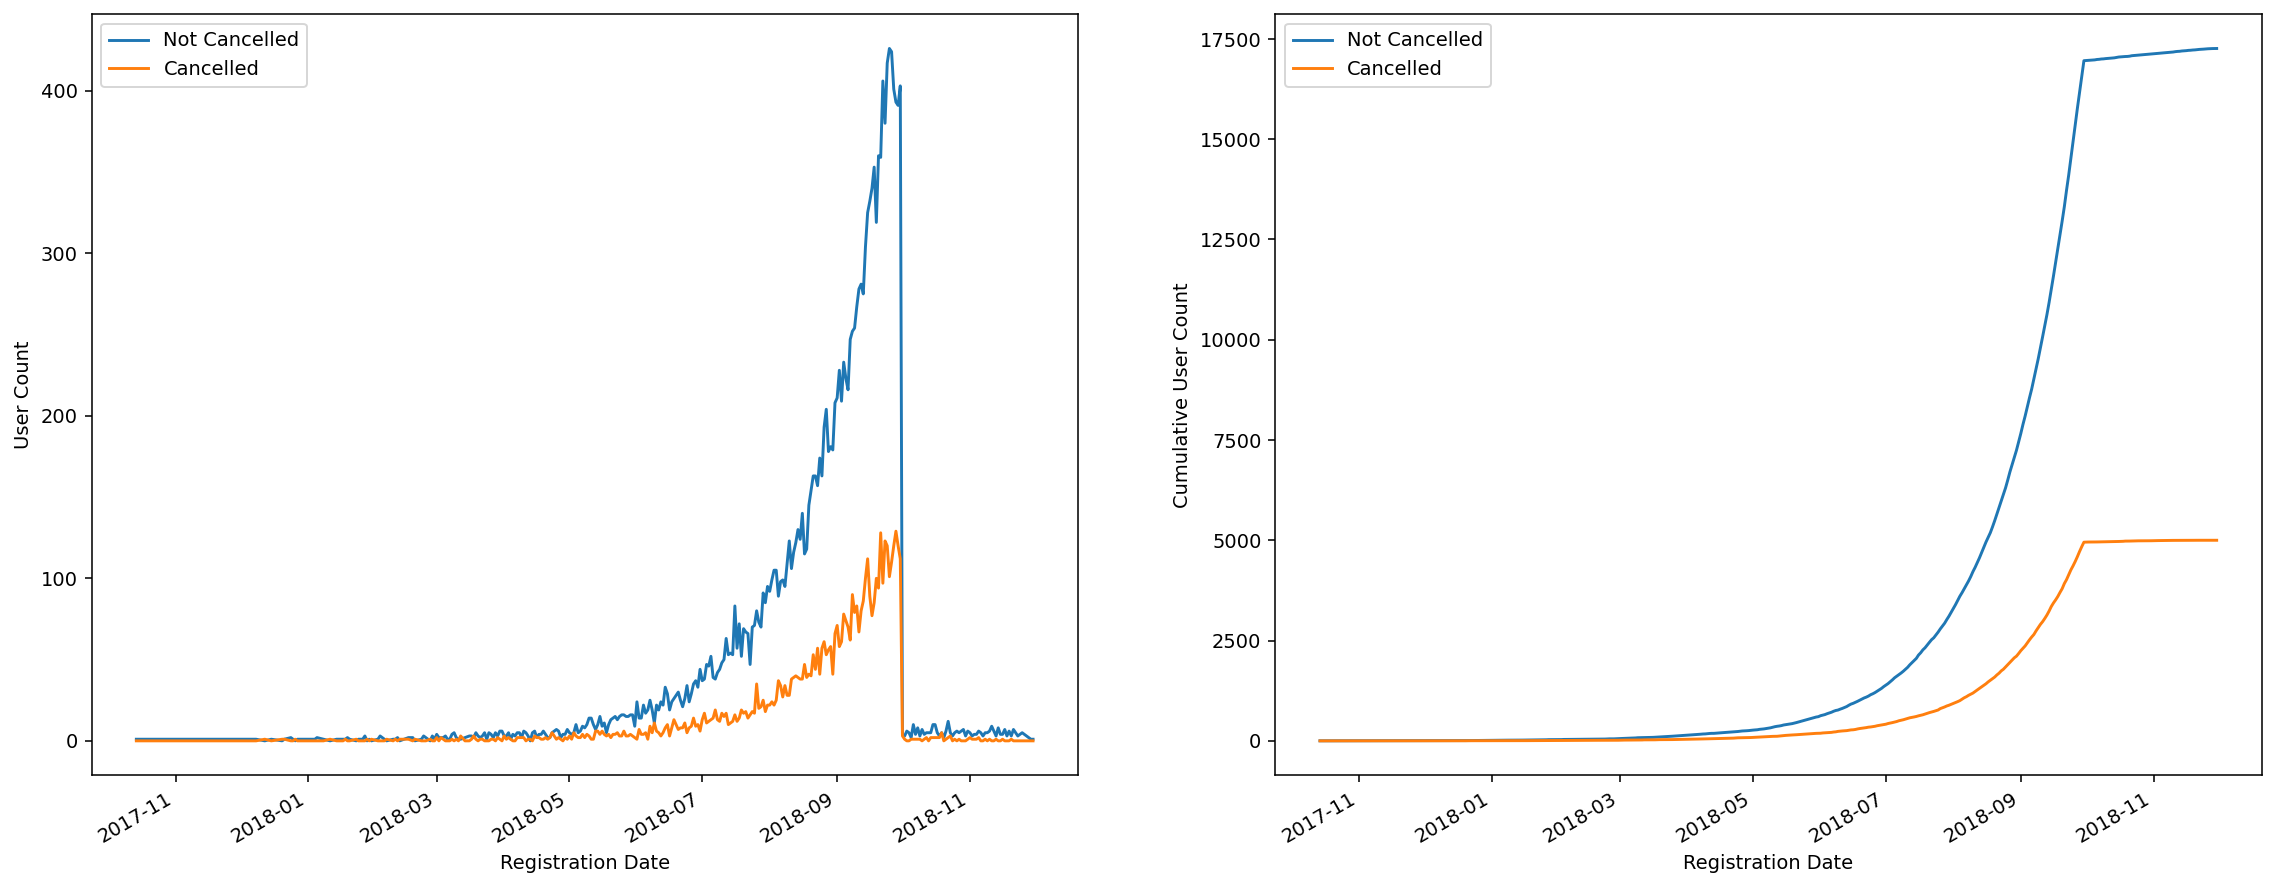

In [17]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

reg_df.plot(ax=axes[0], xlabel="Registration Date", ylabel="User Count")
reg_df_cumsum.plot(ax=axes[1], xlabel="Registration Date", ylabel="Cumulative User Count")

In [18]:
# Last Activity date
last_activity_date = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.ts, churn.label FROM
    (
        SELECT userIdIndex, MAX(date(timestamp)) AS ts FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [19]:
lad_df = last_activity_date.toPandas()
lad_df = lad_df.pivot(index="ts", columns="label").fillna(0)
lad_df.columns = ["Not Cancelled", "Cancelled"]
lad_df_cumsum = lad_df.cumsum()

<AxesSubplot:xlabel='Last Activity Date', ylabel='Cumulative User Count'>

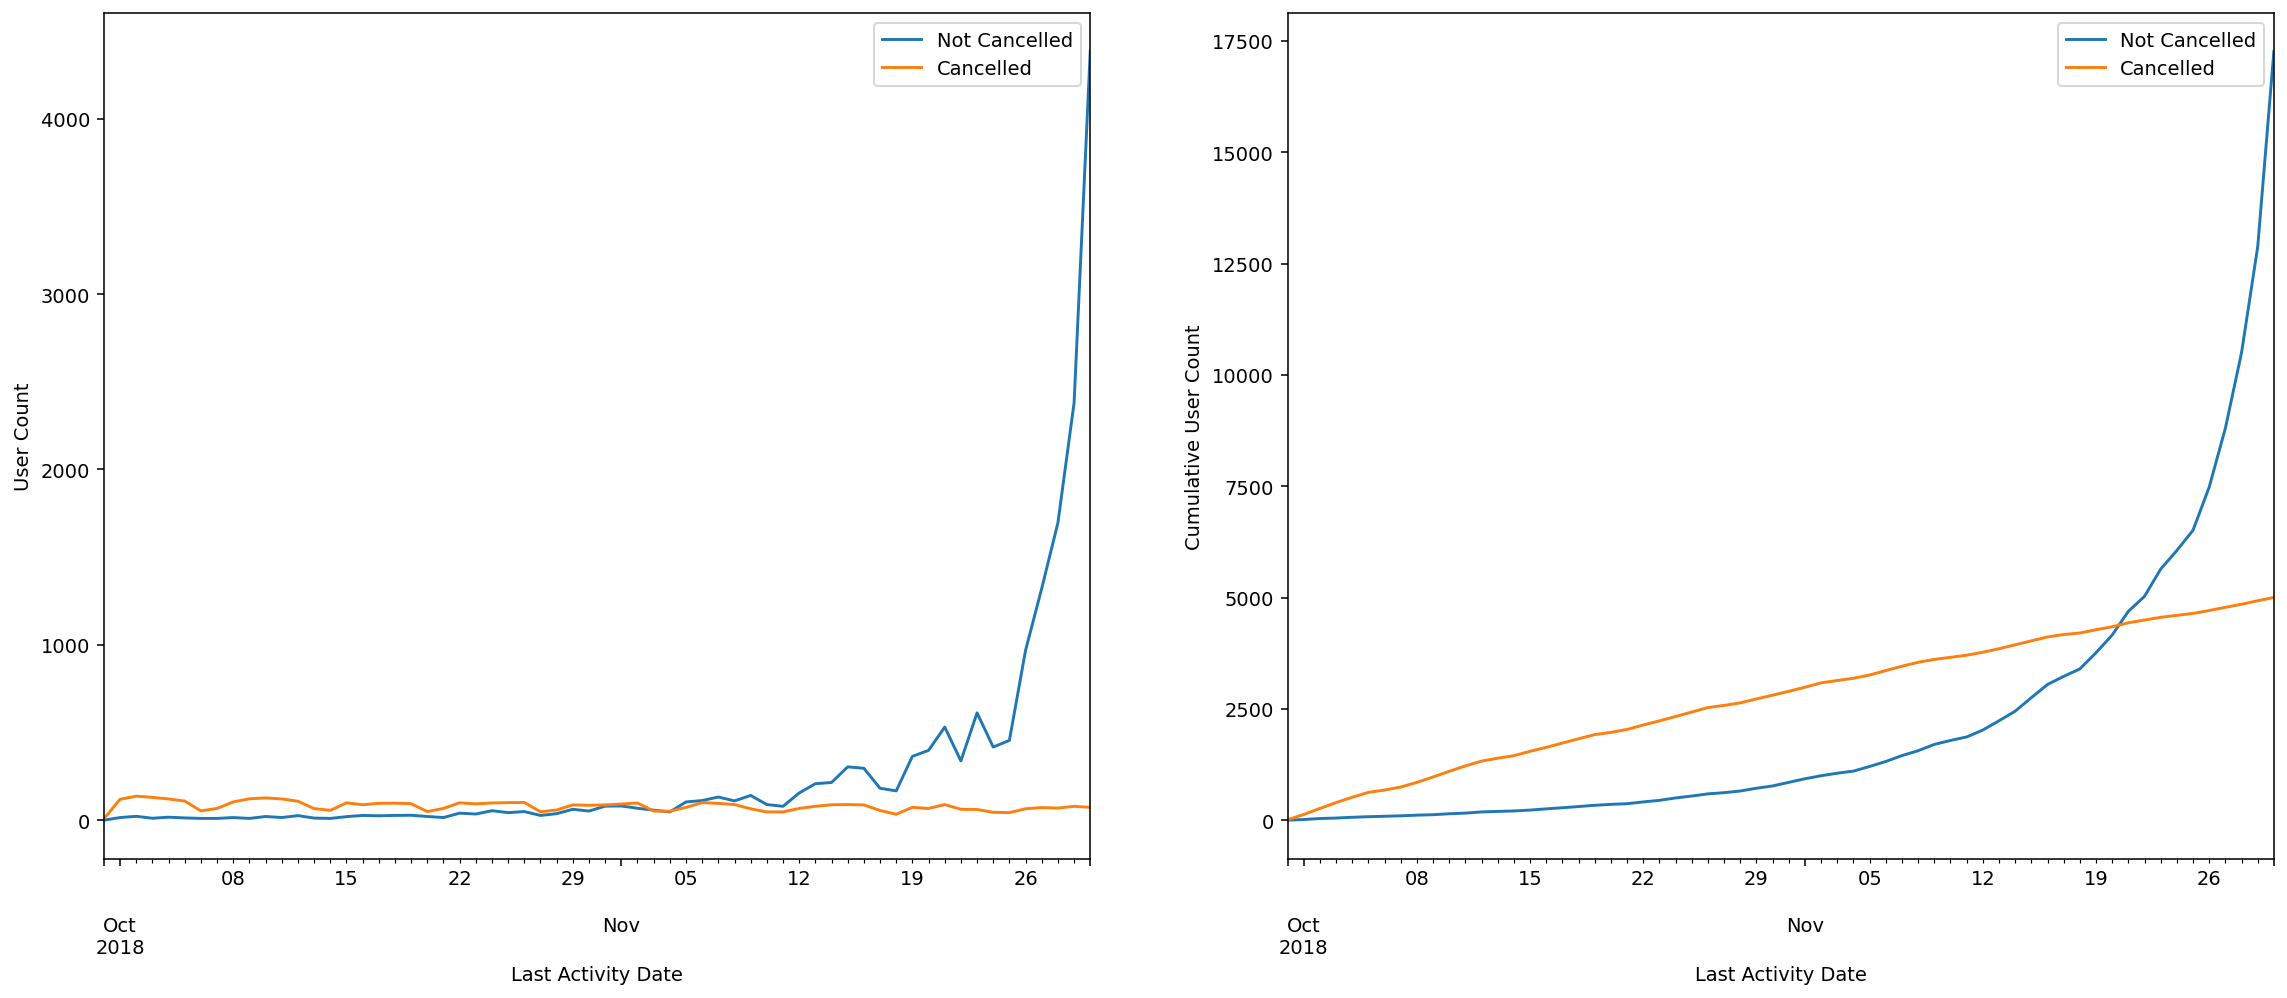

In [20]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

lad_df.plot(ax=axes[0], xlabel="Last Activity Date", ylabel="User Count")
lad_df_cumsum.plot(ax=axes[1], xlabel="Last Activity Date", ylabel="Cumulative User Count")

In [21]:
# Mean User Age Date by Activity Date
mean_user_age = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS users, AVG(age) AS age FROM
(
    SELECT events.userIdIndex, events.ts, events.age, churn.label FROM
    (
        SELECT userIdIndex, date(timestamp) AS ts, AVG(elapsed_days) AS age FROM sparkify_events
        GROUP BY userIdIndex, date(timestamp)
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [22]:
mean_user_age_df = mean_user_age.toPandas()

mua_df = mean_user_age_df.pivot(index="ts", columns="label", values="age").fillna(0)
mua_df.columns = ["Not Cancelled", "Cancelled"]

user_count_df = mean_user_age_df.pivot(index="ts", columns="label", values="users").fillna(0)
user_count_df.columns = ["Not Cancelled", "Cancelled"]

<AxesSubplot:xlabel='Activity Date', ylabel='User Count'>

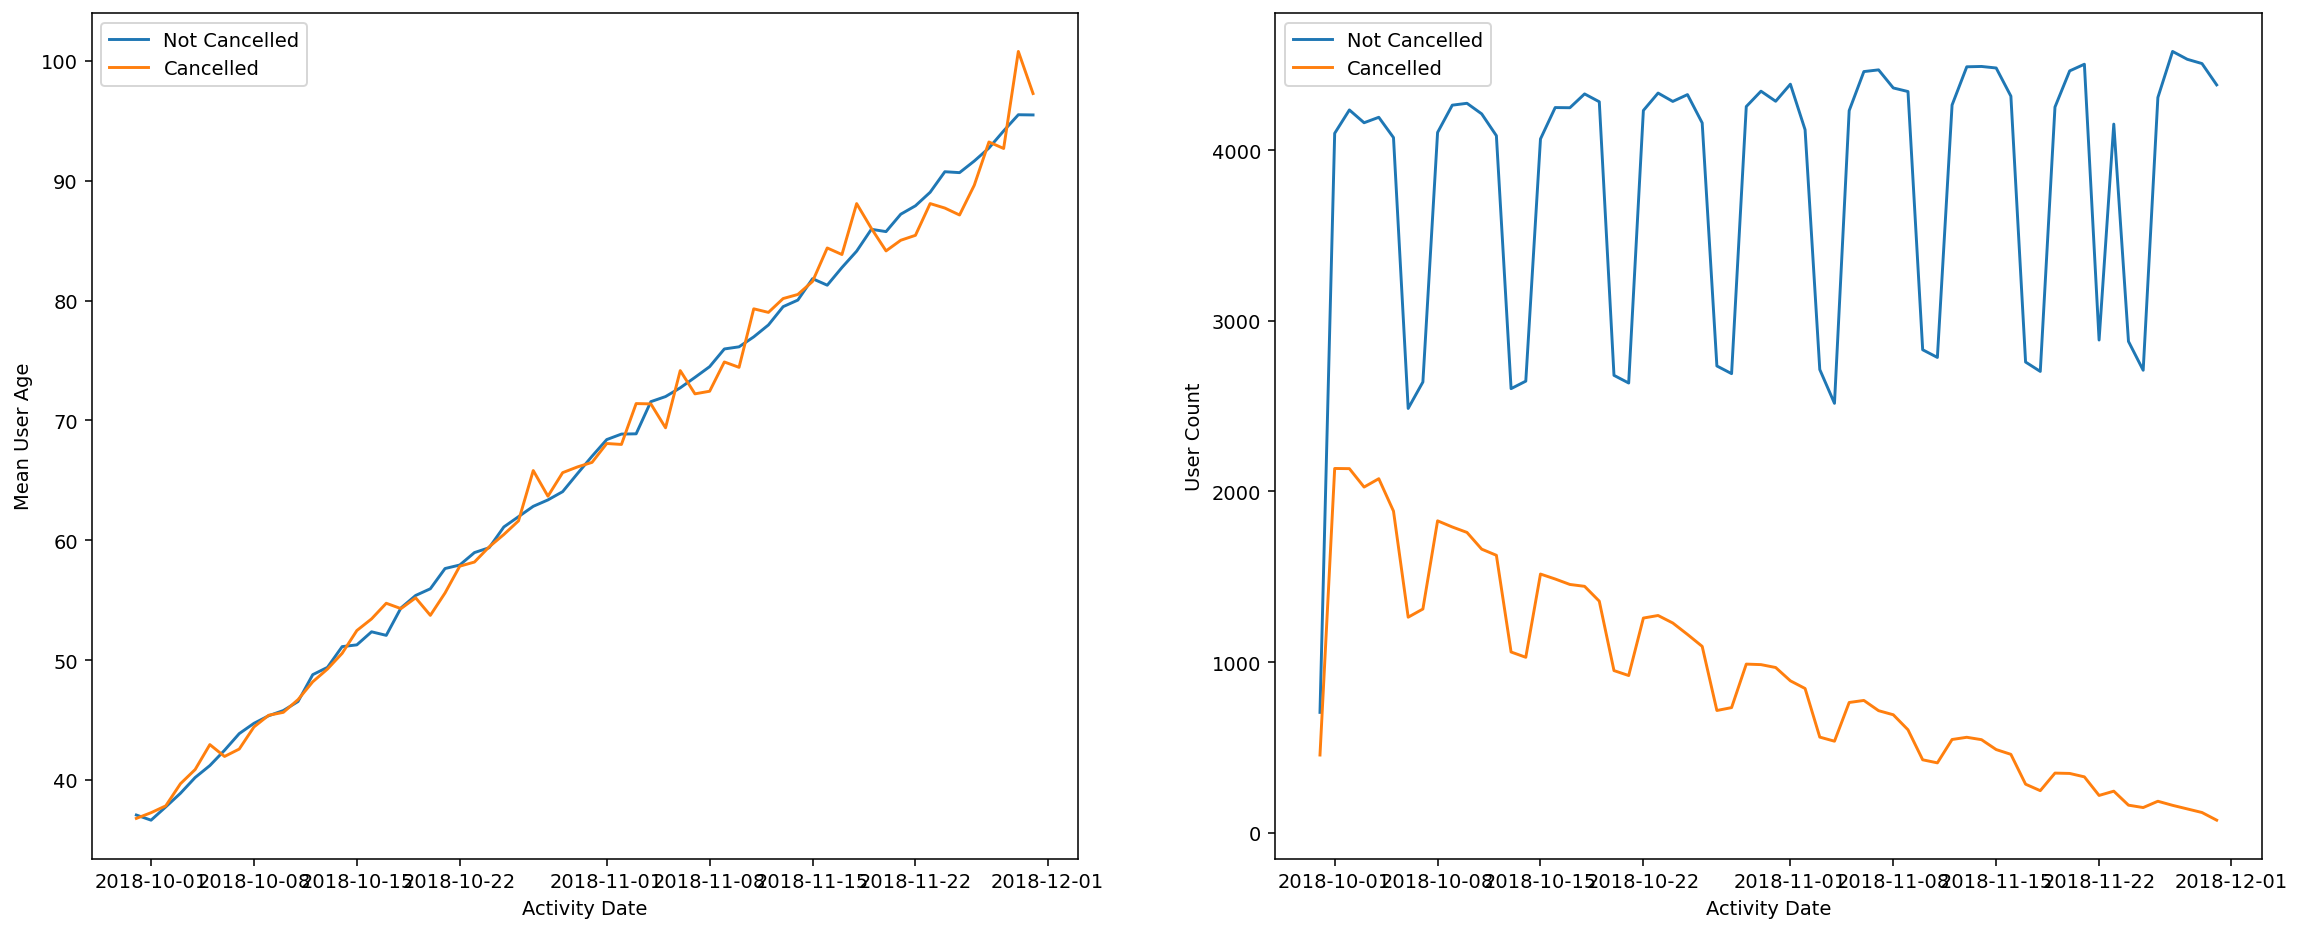

In [23]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

mua_df.plot(ax=axes[0], xlabel="Activity Date", ylabel="Mean User Age")
user_count_df.plot(ax=axes[1], xlabel="Activity Date", ylabel="User Count")

In [24]:
# User age distribution
user_age = spark.sql("""
SELECT events.userIdIndex, age, avg_age, label FROM 
(
    SELECT userIdIndex, MAX(elapsed_days) AS age, AVG(elapsed_days) AS avg_age
    FROM sparkify_events
    GROUP BY userIdIndex
) AS events
INNER JOIN churn ON churn.userIdIndex = events.userIdIndex
""")

In [25]:
user_age_df = user_age.toPandas()

Text(0, 0.5, 'User Count')

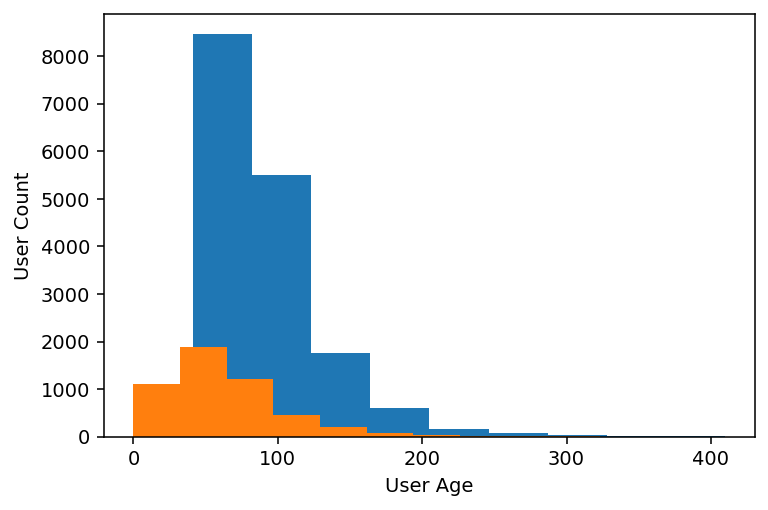

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

user_age_df.loc[user_age_df["label"] == 0, "age"].plot(ax=axes, kind="hist")
user_age_df.loc[user_age_df["label"] == 1, "age"].plot(ax=axes, kind="hist")

axes.set_xlabel("User Age")
axes.set_ylabel("User Count")

Text(0, 0.5, 'User Count')

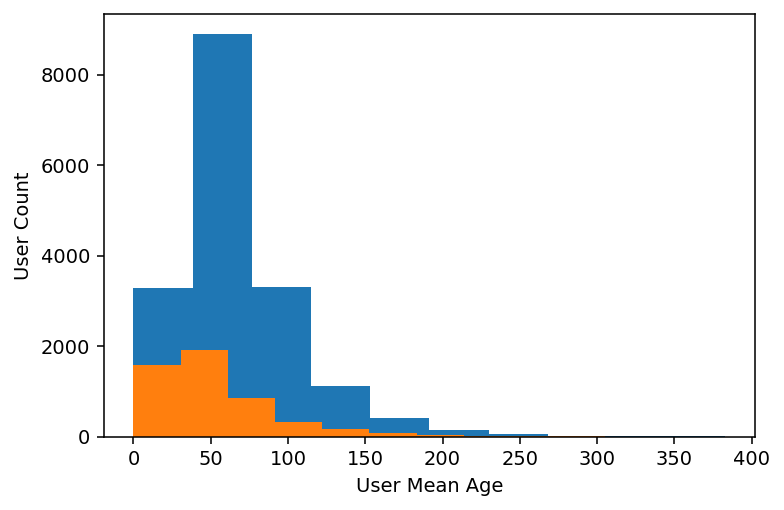

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

user_age_df.loc[user_age_df["label"] == 0, "avg_age"].plot(ax=axes, kind="hist")
user_age_df.loc[user_age_df["label"] == 1, "avg_age"].plot(ax=axes, kind="hist")

axes.set_xlabel("User Mean Age")
axes.set_ylabel("User Count")

In [28]:
user_age_df.loc[user_age_df["label"] == 0, "age"].describe()

count    17262.000000
mean        89.154212
std         38.889514
min          0.000000
25%         65.000000
50%         79.000000
75%        105.000000
max        410.000000
Name: age, dtype: float64

In [29]:
user_age_df.loc[user_age_df["label"] == 1, "age"].describe()

count    5001.000000
mean       63.748050
std        41.260171
min         0.000000
25%        35.000000
50%        56.000000
75%        82.000000
max       323.000000
Name: age, dtype: float64

In [30]:
user_age_df.loc[user_age_df["label"] == 0, "avg_age"].describe()

count    17262.000000
mean        67.279668
std         38.269776
min          0.000000
25%         41.666473
50%         57.473129
75%         82.499187
max        382.929058
Name: avg_age, dtype: float64

In [31]:
user_age_df.loc[user_age_df["label"] == 1, "avg_age"].describe()

count    5001.000000
mean       52.292560
std        38.644619
min         0.000000
25%        26.142915
50%        42.804444
75%        67.339450
max       305.412853
Name: avg_age, dtype: float64

In [32]:
# Check song played during time
song_played_per_user_per_day = spark.sql("""
SELECT user_age_when_played, label, 
       COUNT(userIdIndex) AS users_count, 
       SUM(songs_played) AS songs_played, 
       AVG(songs_played) AS avg_songs_played, 
       STD(songs_played) AS std_songs_played,
       SUM(page_interactions) AS page_interactions,
       AVG(page_interactions) AS avg_page_interactions,
       STD(page_interactions) AS std_page_interactions
FROM 
(
    SELECT events.userIdIndex, events.user_age_when_played, events.songs_played, events.page_interactions, churn.label FROM 
    (
        SELECT userIdIndex, elapsed_days AS user_age_when_played, SUM(IF(page = 'NextSong', 1, 0)) AS songs_played, SUM(IF(page = 'NextSong', 0, 1)) AS page_interactions 
        FROM sparkify_events
        GROUP BY userIdIndex, elapsed_days
    ) AS events
    INNER JOIN churn
    ON events.userIdIndex = churn.userIdIndex
) AS table2
GROUP BY label, user_age_when_played
ORDER BY user_age_when_played, label
""")

In [33]:
sppupd_df = song_played_per_user_per_day.toPandas()
sppupd_df = sppupd_df.pivot(index="user_age_when_played", columns="label")

<AxesSubplot:xlabel='User Age When Event Happened', ylabel='User Count'>

<Figure size 1120x840 with 0 Axes>

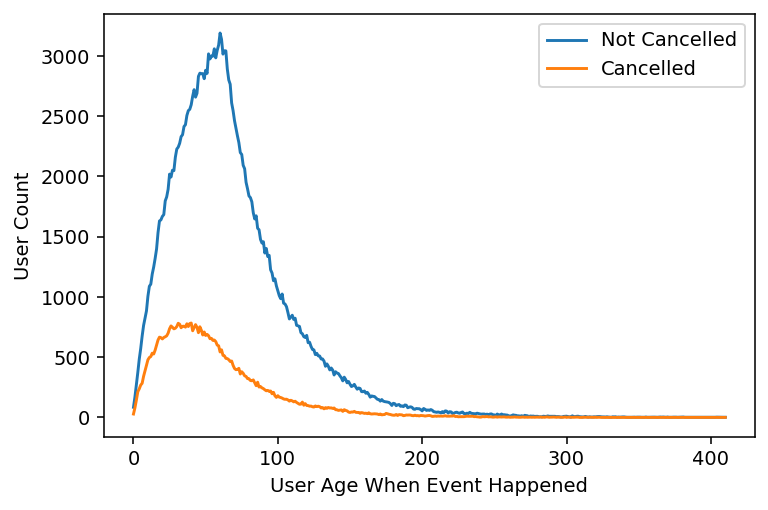

In [34]:
uc = sppupd_df["users_count"].fillna(0)
uc.columns = ["Not Cancelled", "Cancelled"]

plt.figure(figsize=(8, 6))
uc.plot(xlabel="User Age When Event Happened", ylabel="User Count")

<AxesSubplot:title={'center':'Std Page Interactions'}, xlabel='Activity Date', ylabel='Page Interactions'>

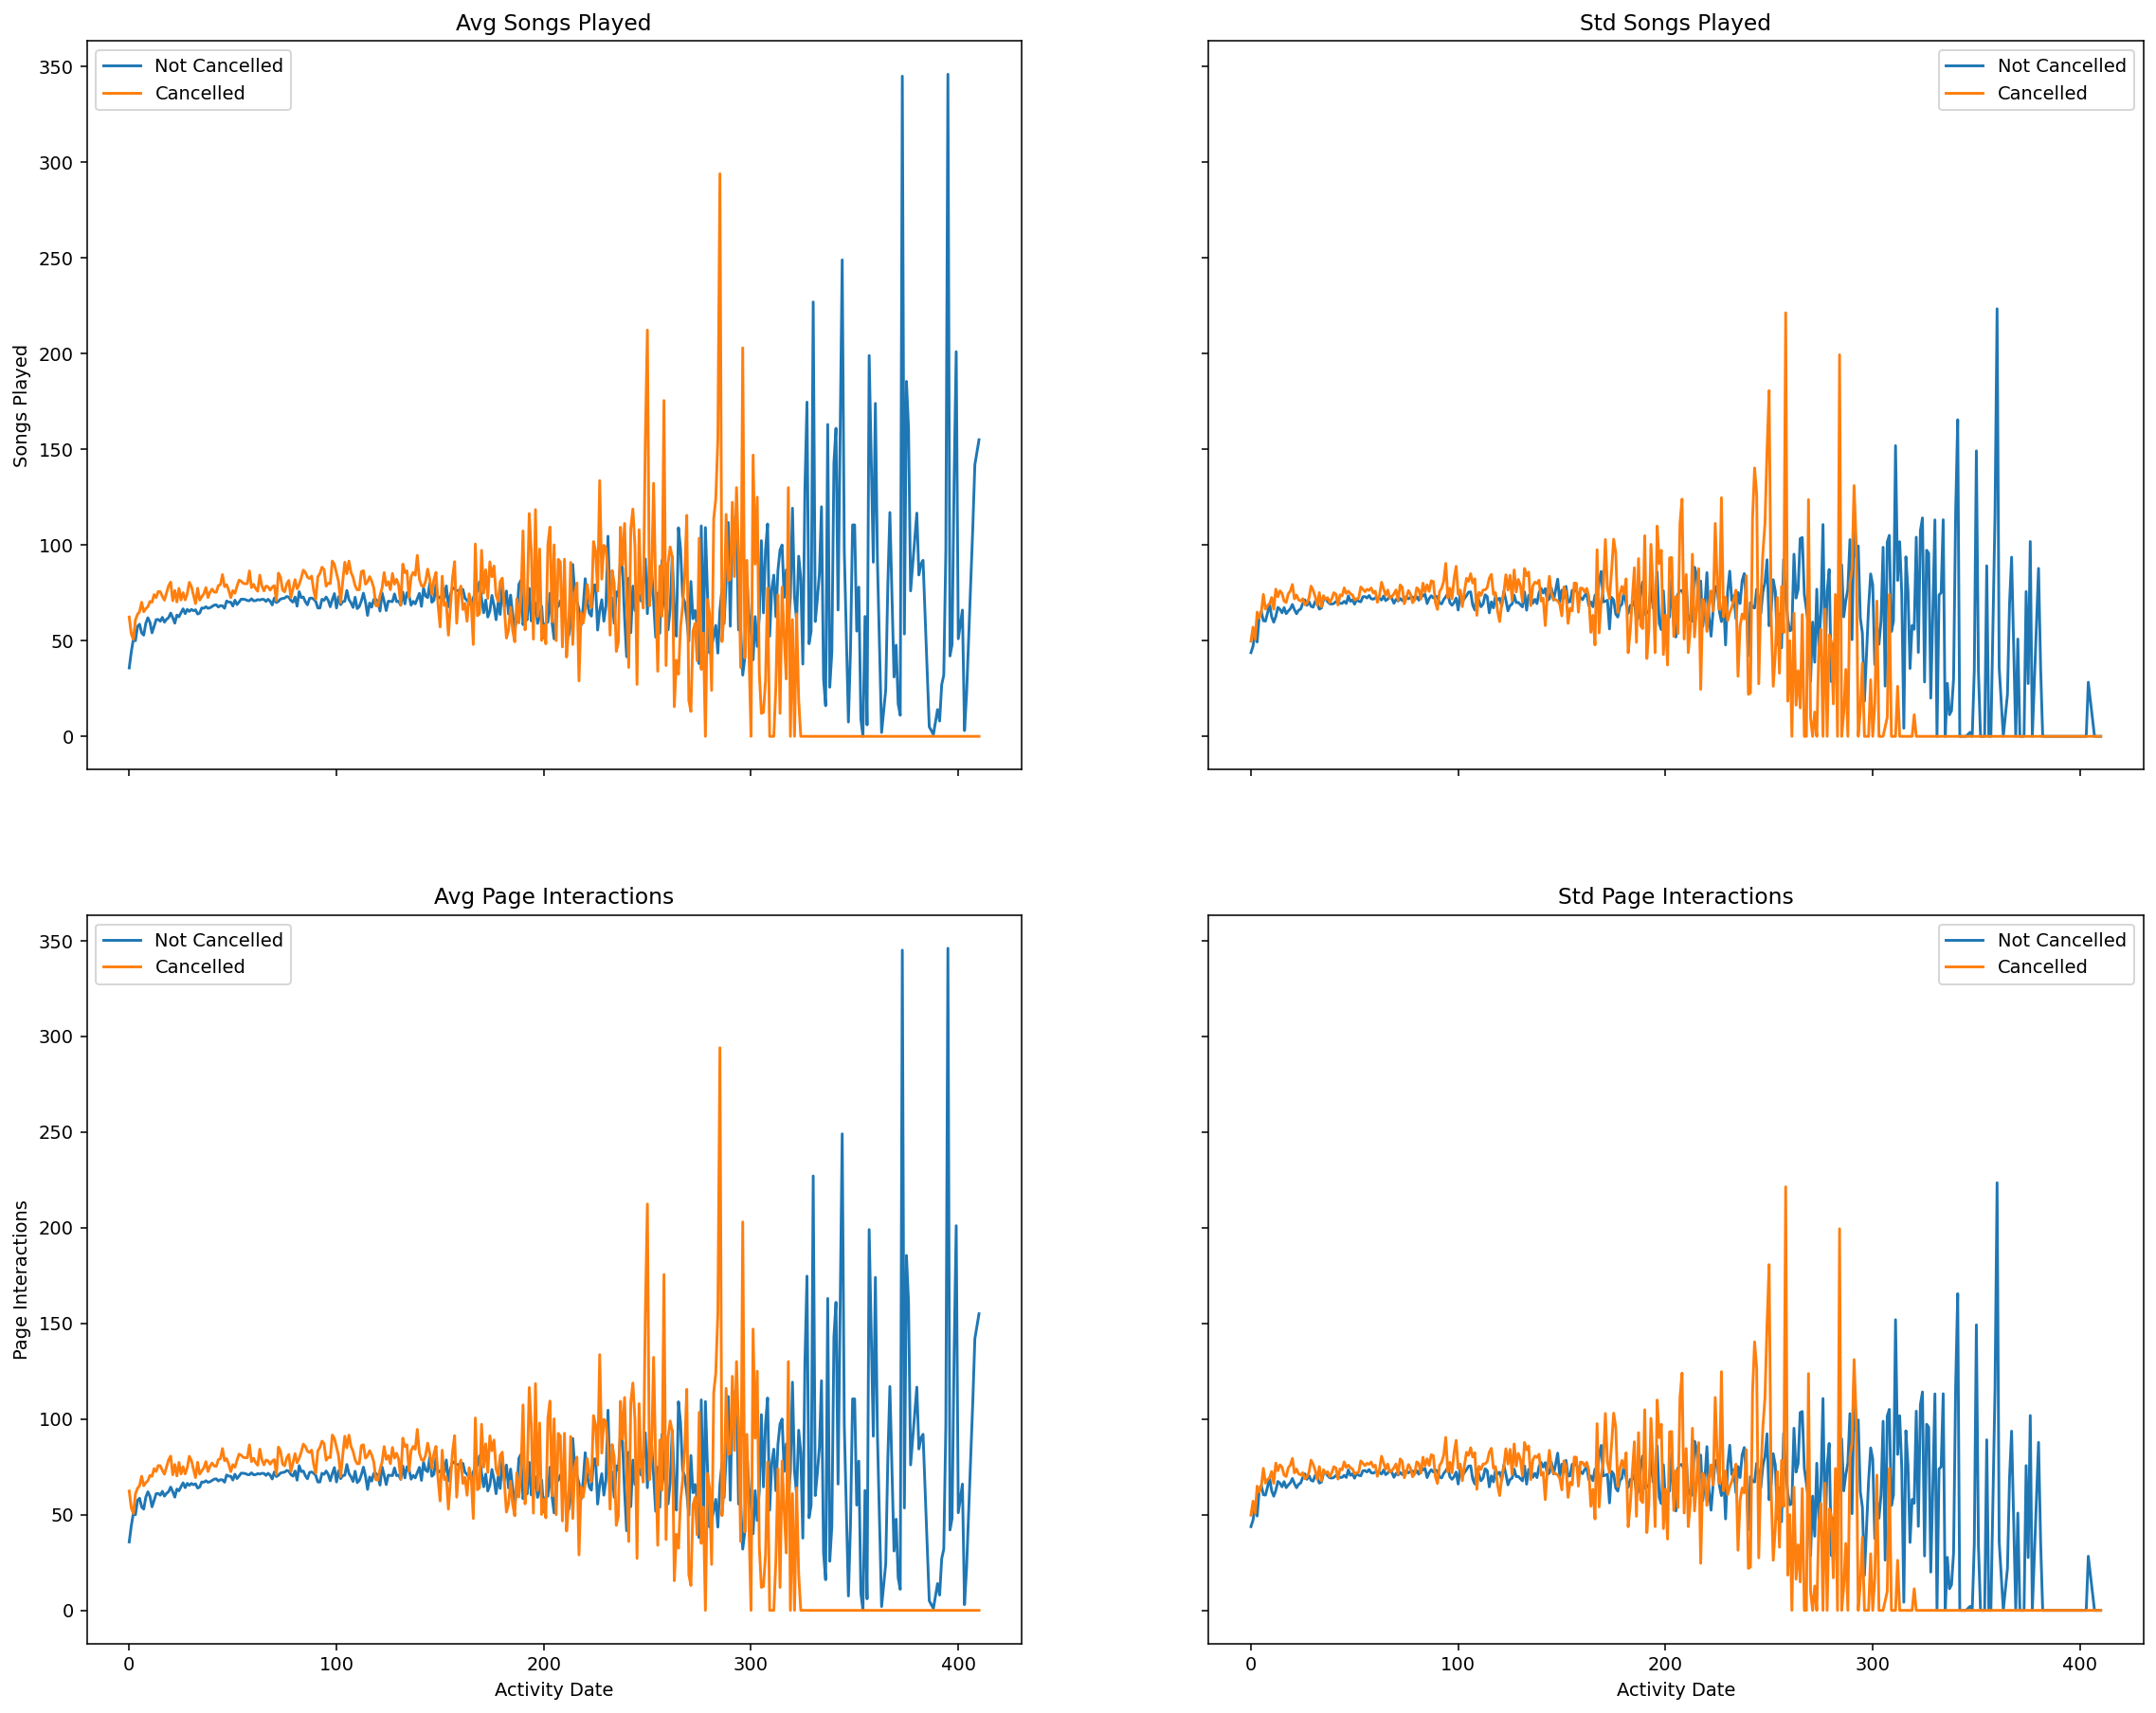

In [35]:
asp_df = sppupd_df["avg_songs_played"].fillna(0)
asp_df.columns = ["Not Cancelled", "Cancelled"]

api_df = sppupd_df["avg_page_interactions"].fillna(0)
api_df.columns = ["Not Cancelled", "Cancelled"]

ssp_df = sppupd_df["std_songs_played"].fillna(0)
ssp_df.columns = ["Not Cancelled", "Cancelled"]

spi_df = sppupd_df["std_page_interactions"].fillna(0)
spi_df.columns = ["Not Cancelled", "Cancelled"]

fig, axes = plt.subplots(figsize=(20, 16), nrows=2, ncols=2, sharex=True, sharey=True)

asp_df.plot(ax=axes[0, 0], xlabel="Activity Date", ylabel="Songs Played", title="Avg Songs Played")
ssp_df.plot(ax=axes[0, 1], xlabel="Activity Date", ylabel="Songs Played", title="Std Songs Played")

asp_df.plot(ax=axes[1, 0], xlabel="Activity Date", ylabel="Page Interactions", title="Avg Page Interactions")
ssp_df.plot(ax=axes[1, 1], xlabel="Activity Date", ylabel="Page Interactions", title="Std Page Interactions")

In [36]:
# Sessions behavior
sessions = spark.sql("""
SELECT activity_time, label,
       COUNT(sessionId) AS sessions, 
       AVG(interactions) AS interactions, 
       AVG(session_time) AS session_time
FROM
(
    SELECT events.userIdIndex, events.interactions, events.sessionId, events.session_time, events.activity_time, churn.label FROM 
    (
        SELECT userIdIndex, sessionId, COUNT(sessionId) AS interactions, MIN(elapsed_days) AS activity_time, (MAX(ts) - MIN(ts))/1000 AS session_time 
        FROM sparkify_events
        GROUP BY userIdIndex, sessionId
    ) AS events
    INNER JOIN churn
    ON events.userIdIndex = churn.userIdIndex
)
GROUP BY activity_time, label
ORDER BY activity_time, label
""")

In [37]:
sessions_df = sessions.toPandas()
sessions_df = sessions_df.pivot(index="activity_time", columns="label").fillna(0)

<AxesSubplot:title={'center':'Mean Session Time per Activity Day'}, xlabel='Activity Day', ylabel='Mean Session Time (s)'>

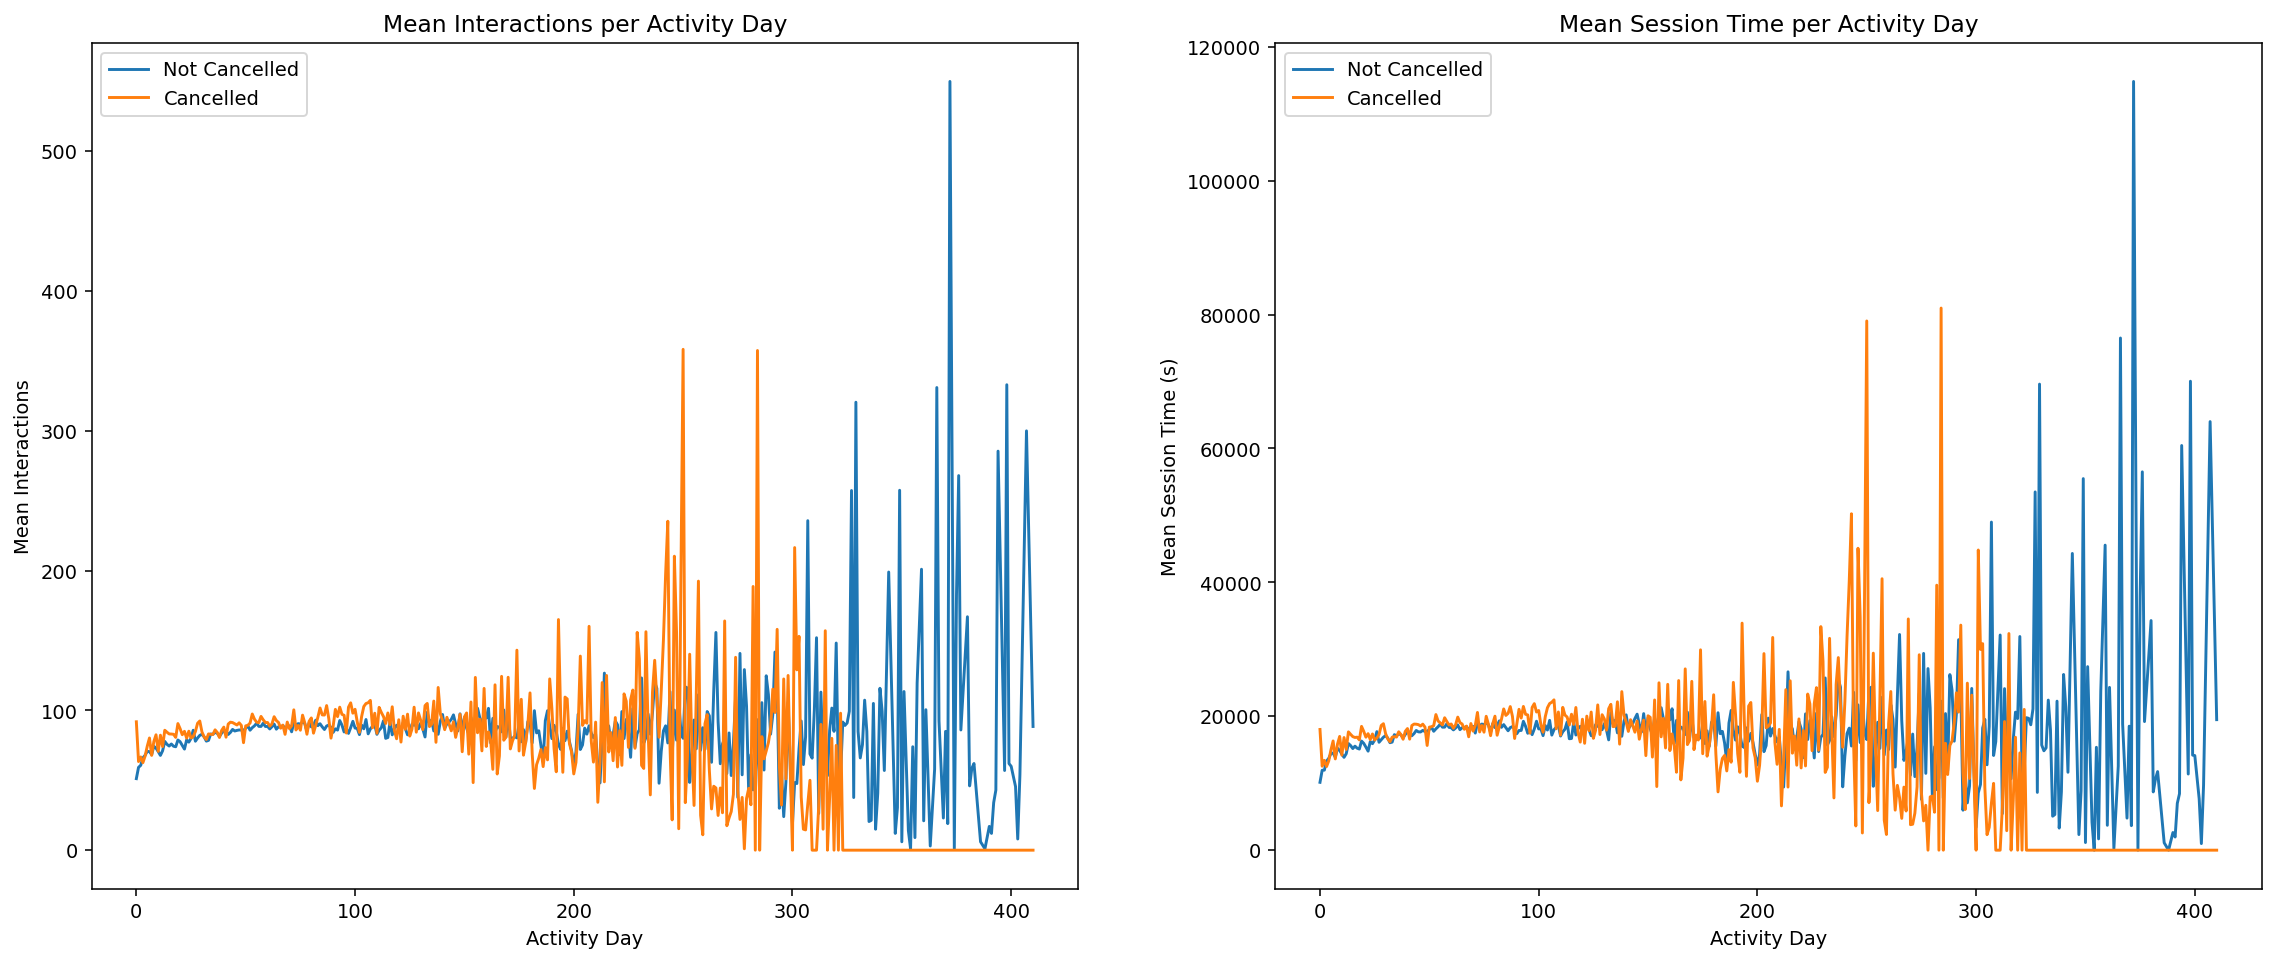

In [38]:
si_df = sessions_df["interactions"].fillna(0)
si_df.columns = ["Not Cancelled", "Cancelled"]

sst_df = sessions_df["session_time"].fillna(0)
sst_df.columns = ["Not Cancelled", "Cancelled"]

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

si_df.plot(ax=axes[0], xlabel="Activity Day", ylabel="Mean Interactions", title="Mean Interactions per Activity Day")
sst_df.plot(ax=axes[1], xlabel="Activity Day", ylabel="Mean Session Time (s)", title="Mean Session Time per Activity Day")

In [39]:
# Number of distinct artists and songs
spark.sql("""
SELECT COUNT(DISTINCT artist), COUNT(DISTINCT song) FROM sparkify_events
""").toPandas()

,count(DISTINCT artist),count(DISTINCT song)
0,38336,253548


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
# Helper function to prefix columns
# Must have userIdIndex
def prefix_column(dataframe, prefix):
    """Prefix the columns of a dataframe
    
    Args:
        dataframe (object): A Spark Dataframe with a userIdIndex column, and several other columns
        prefix (str): The string to prefix the other columns
        
    Returns:
        object: A Spark Dataframe with renamed columns
    
    """
    cols = dataframe.columns.copy()
    cols.remove("userIdIndex")
    
    for col in cols:
        dataframe = dataframe.withColumnRenamed(col, f"{prefix}_{col}")

    return dataframe

In [41]:
# Create features for Artists
# Because of the large number of artists, do a dimensionality reduction with ALS

In [42]:
# Create an artist rating View for each user
# For each user the rating is the number of songs played for that artist divided by the most song counts of an artist
# Range between 0-1
def create_ratings(table_name):
    """Create a ratings dataframe for a given table with events
    
    Args:
        table_name (str): The name of SQL table
    """
    rating_df = spark.sql(f"""
    SELECT userIdIndex, artistIndex, COUNT(song) / MAX(COUNT(song)) OVER(PARTITION BY userIdIndex) AS rating
    FROM {table_name}
    WHERE artist IS NOT NULL
    GROUP BY userIdIndex, artistIndex
    """)
    
    rating_df.createOrReplaceTempView(f"{table_name}_rating")

# Create ratings for both total and last week events
create_ratings("sparkify_events")
create_ratings("last_week_events")

In [43]:
# Get rating dataframe for whole dataset
rating_df = spark.sql("SELECT * FROM sparkify_events_rating")

In [44]:
# Create ALS model and train (Reduce to 20 features)
als = ALS(rank=20, 
          regParam=0.01,
          userCol="userIdIndex",
          itemCol="artistIndex",
          ratingCol="rating",
          coldStartStrategy="drop")

model = als.fit(rating_df)

In [45]:
# Get item factors matrix from ALS model
factors = IndexedRowMatrix(model.itemFactors.rdd.map(tuple)).toBlockMatrix().toLocalMatrix()

def get_als_features(ratings, factors, num_factors=20, output_col="vector"):
    """Get features for each user given the ratings dataframe and the item factor matrix.
    
    Args:
        ratings (object): A Spark Dataframe with the columns userIdIndex, artistIndex and rating
        factors (IndexedRowMatrix): A Matrix with Item Factors from a trained ALS model
        output_col (str): The name of the output column features
        
    Returns:
        object: A Spark Dataframe with columns userIdIndex and several output_col in the number of number
        of factors
        
    """
    mat = CoordinateMatrix(ratings.select("userIdIndex", "artistIndex", "rating").rdd.map(tuple))
    mat = mat.toIndexedRowMatrix()
    
    # Dot multiplication between user-artist ratings matrix and artist factors
    dataframe = mat.multiply(factors).rows.toDF()
    
    # Transform array to columns
    dataframe = dataframe.withColumn("userIdIndex", dataframe["index"].cast(DoubleType()))
    dataframe = dataframe.withColumn(output_col, vector_to_array("vector"))
    dataframe = dataframe.select(["userIdIndex"] + [dataframe[output_col][i] for i in range(num_factors)])
       
    return dataframe


# All events
als_features_all = get_als_features(rating_df, factors, output_col="als_features_all")

# Last week events
rating_last_week_df = spark.sql("""
SELECT t.userIdIndex, t.artistIndex, IFNULL(lw.rating, 0) AS rating FROM sparkify_events_rating AS t 
LEFT JOIN last_week_events_rating AS lw
ON t.userIdIndex = lw.userIdIndex AND t.artistIndex = lw.artistIndex
""")
als_features_lw = get_als_features(rating_last_week_df, factors, output_col="als_features_lw")

In [46]:
## Percentage of access for each page for each user
# Remove Cancel and Cancellation Confirmation
def create_page_percentage(table_name):
    """For each user calculate the percentage of a 
    specific page interaction over all pages interactions.
    
    Remove page `Cancel` and `Cancellation Confirmation` 
    because they are used to predict churn, not to serve as features.
    
    Args:
        table_name (str): A Spark SQL table name
    
    Returns:
        object: A Spark Dataframe
    
    """
    
    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) / SUM(COUNT(page)) OVER(PARTITION BY userIdIndex) AS page_perct
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)
    
    return page_df

# All events
page_pct_all = create_page_percentage("sparkify_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_all = prefix_column(page_pct_all, prefix="page_pct_all")

# Last week events
page_pct_lw = create_page_percentage("last_week_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_lw = prefix_column(page_pct_lw, prefix="page_pct_lw")

In [47]:
# Total page access
def create_page_counts(table_name):
    """Calculate the number of pages access for each user
    
    Remove page `Cancel` and `Cancellation Confirmation` 
    because they are used to predict churn, not to serve as features.
    
    Args:
        table_name (str): A Spark SQL table name
    
    Returns:
        object: A Spark Dataframe
    """
    
    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) AS page_count
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)
    
    return page_df

# All events
page_count_all = create_page_counts("sparkify_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_all = prefix_column(page_count_all, prefix="page_count_all")

# Last week events
page_count_lw = create_page_counts("last_week_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_lw = prefix_column(page_count_lw, prefix="page_count_lw")

In [48]:
# Level of each user by getting its last reported level
level_indexer = StringIndexer(inputCol="level", outputCol="levelIndex")
level_encoder = OneHotEncoder(inputCols=["levelIndex"], outputCols=["l"])

level = spark.sql(
"""
WITH last_level AS 
(
    SELECT userIdIndex, level, ROW_NUMBER() OVER (PARTITION BY userIdIndex ORDER BY ts DESC) AS number
    FROM sparkify_events
)
SELECT userIdIndex, level FROM last_level WHERE number = 1
""")

level = level_indexer.fit(level).transform(level)
level = level_encoder.fit(level).transform(level).select("userIdIndex", "l")
level = level.withColumnRenamed("l", "level")

In [49]:
# Level percentage
# Drop free (because paid = 1 - free, no necessity to have both as they are linearly dependent, thus highly correlated)
def create_level_percentage(table_name):
    """Calculate the level percentage for each user by using the number of events
    that happened in each level
       
    Args:
        table_name (str): A Spark SQL table name
    
    Returns:
        object: A Spark Dataframe
    """
    
    level_df = spark.sql(f"""
    SELECT userIdIndex, level, COUNT(level) / SUM(COUNT(level)) OVER(PARTITION BY userIdIndex) AS level_perct
    FROM {table_name}
    WHERE level IS NOT NULL
    GROUP BY userIdIndex, level
    """)
    
    return level_df

# All events
level_pct_all = create_level_percentage("sparkify_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_all = prefix_column(level_pct_all, prefix="level_pct_all")

# Last week events
level_pct_lw = create_level_percentage("last_week_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_lw = prefix_column(level_pct_lw, prefix="level_pct_lw")

In [50]:
# Gender
gender_encoder = OneHotEncoder(inputCols=["genderIndex"], outputCols=["g"])
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")

gender = df.groupBy("userIdIndex").agg(F.first("gender").alias("gender"))
gender = gender_indexer.fit(gender).transform(gender)
gender = gender_encoder.fit(gender).transform(gender).select("userIdIndex", "g")
gender = gender.withColumnRenamed("g", "gender")

In [51]:
# Song length
song_length_all = df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_all = prefix_column(song_length_all, prefix="song_length_all")

song_length_lw = last_week_df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_lw = prefix_column(song_length_lw, prefix="song_length_lw")

In [52]:
# Hourly Song Counts
hourly_song_counts_all = df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_all = prefix_column(hourly_song_counts_all, prefix="hourly_song_counts_all")

hourly_song_counts_lw = last_week_df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_lw = prefix_column(hourly_song_counts_lw, prefix="hourly_song_counts_lw")

In [53]:
# Hourly Mean Song Length
hourly_mean_song_length_all = df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_all = prefix_column(hourly_mean_song_length_all, prefix="hourly_mean_song_length_all")

hourly_mean_song_length_lw = last_week_df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_lw = prefix_column(hourly_mean_song_length_lw, prefix="hourly_mean_song_length_lw")

In [54]:
elapsed_days = spark.sql("""
SELECT userIdIndex, MAX(elapsed_days) AS age, AVG(elapsed_days) AS avg_age
FROM sparkify_events
GROUP BY userIdIndex
""")

In [55]:
sessions = spark.sql("""
SELECT userIdIndex, 
       COUNT(sessionId) AS sessions_count, 
       AVG(pages_accessed) AS sessions_avg_pages_accessed,
       AVG(count_artists) AS sessions_avg_count_artists,
       AVG(avg_song_length) AS sessions_avg_song_length,
       AVG(session_time) AS sessions_avg_session_time,
       STD(pages_accessed) AS sessions_std_pages_accessed,
       STD(count_artists) AS sessions_std_count_artists,
       STD(avg_song_length) AS sessions_std_song_length,
       STD(session_time) AS sessions_std_session_time
FROM
(
    SELECT userIdIndex, sessionId, COUNT(song) AS songs_played, COUNT(page) AS pages_accessed, 
           COUNT(DISTINCT artist) AS count_artists, AVG(length) AS avg_song_length, 
           (MAX(ts) - MIN(ts)) / 1000 AS session_time       
    FROM sparkify_events
    GROUP BY userIdIndex, sessionId
)
GROUP BY userIdIndex
""")
# Fill std NAs with 0
sessions = sessions.fillna(0.)

In [56]:
# Features Dataframe with last week
a1 = als_features_all.join(als_features_lw, on=["userIdIndex"])
p1 = page_pct_all.join(page_pct_lw, on=["userIdIndex"])
p2 = page_count_all.join(page_count_lw, on=["userIdIndex"])
l1 = level_pct_all.join(level_pct_lw, on=["userIdIndex"])
s1 = song_length_all.join(song_length_lw, on=["userIdIndex"])
h1 = hourly_song_counts_all.join(hourly_song_counts_lw, on=["userIdIndex"])
h2 = hourly_mean_song_length_all.join(hourly_mean_song_length_lw, on=["userIdIndex"])

In [57]:
features = a1.join(p1, on=["userIdIndex"])\
             .join(p2, on=["userIdIndex"])\
             .join(l1, on=["userIdIndex"])\
             .join(s1, on=["userIdIndex"])\
             .join(h1, on=["userIdIndex"])\
             .join(h2, on=["userIdIndex"])\
             .join(elapsed_days, on=["userIdIndex"])\
             .join(sessions, on=["userIdIndex"])\
             .join(churn, on=["userIdIndex"])

In [58]:
features.printSchema()

root
 |-- userIdIndex: double (nullable = true)
 |-- als_features_all[0]: double (nullable = true)
 |-- als_features_all[1]: double (nullable = true)
 |-- als_features_all[2]: double (nullable = true)
 |-- als_features_all[3]: double (nullable = true)
 |-- als_features_all[4]: double (nullable = true)
 |-- als_features_all[5]: double (nullable = true)
 |-- als_features_all[6]: double (nullable = true)
 |-- als_features_all[7]: double (nullable = true)
 |-- als_features_all[8]: double (nullable = true)
 |-- als_features_all[9]: double (nullable = true)
 |-- als_features_all[10]: double (nullable = true)
 |-- als_features_all[11]: double (nullable = true)
 |-- als_features_all[12]: double (nullable = true)
 |-- als_features_all[13]: double (nullable = true)
 |-- als_features_all[14]: double (nullable = true)
 |-- als_features_all[15]: double (nullable = true)
 |-- als_features_all[16]: double (nullable = true)
 |-- als_features_all[17]: double (nullable = true)
 |-- als_features_all[18]:

In [59]:
def assembler(features_df):
    """Transform the features columns into a single feature column as a vector
    
    Args:
        features_df (object): A Spark Dataframe with columns: userIdIndex, several features, label
    
    """
    cols = features_df.columns.copy()
    cols.remove("userIdIndex")
    cols.remove("label")

    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    features_df = assembler.transform(features_df).select("userIdIndex", "features", "label")
    
    return features_df

In [60]:
# Assemble features dataframes
features = assembler(features)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [61]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [62]:
# We will use F1 score as the main metric
# We have few examples of churned users, and accuracy would be high if we predict everyone will not cancel
# This is also a binary classification
# Thus using F1 is a compromise between precision and recall

In [64]:
# Weight by label ratio
calc_weights = F.udf(lambda x: churn_rate if x == 0 else (1. - churn_rate), DoubleType())
features = features.withColumn("weights", calc_weights("label"))

In [67]:
# Split the data into training and test sets 75/25
(training, test) = features.randomSplit([0.75, 0.25], seed=42)

In [69]:
# Scale features
print("Scaling features...")
scaler_model = MaxAbsScaler(inputCol="features", outputCol="scaled_features").fit(training)
training = scaler_model.transform(training)
test = scaler_model.transform(test)

Scaling features...


In [70]:
classifiers_dict = {
    "Logistic Regression": LogisticRegression(featuresCol="scaled_features", weightCol="weights"),
    "Linear SVM": LinearSVC(featuresCol="scaled_features", weightCol="weights")
}

In [71]:
models = {}
predictions = {}
fscores = {}

for clf_name, clf in classifiers_dict.items():
    print(f"Training {clf_name}")
    # Train Model
    models[clf_name] = clf.fit(training)

    # Predict
    predictions[clf_name] = models[clf_name].transform(test)

    # Calculate fscores
    fscores[clf_name] = MulticlassClassificationEvaluator().evaluate(predictions[clf_name])
    print(f"{clf_name}: {fscores[clf_name]}")

Training Logistic Regression
Logistic Regression: 0.8029787078927051
Training Linear SVM
Linear SVM: 0.7979777986742618


In [78]:
# Metrics
pred = predictions["Logistic Regression"].select("label", "prediction").toPandas()
y_true = pred["label"]
y_pred = pred["prediction"]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4376
           1       0.53      0.78      0.63      1283

    accuracy                           0.79      5659
   macro avg       0.73      0.79      0.74      5659
weighted avg       0.83      0.79      0.80      5659



In [79]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

[[3474  902]
 [ 283 1000]]


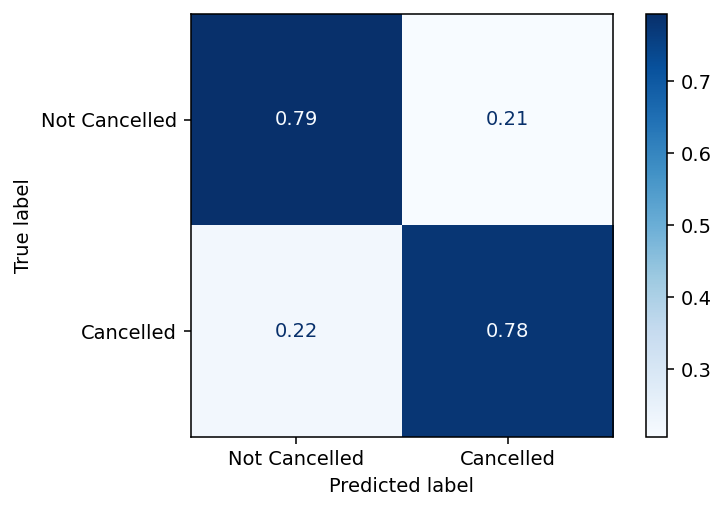

In [80]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Cancelled", "Cancelled"])
disp.plot(cmap=plt.cm.Blues)

In [75]:
f_names = features.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
f_names = [x["name"] for x in f_names]
f_names

['als_features_all[0]',
 'als_features_all[1]',
 'als_features_all[2]',
 'als_features_all[3]',
 'als_features_all[4]',
 'als_features_all[5]',
 'als_features_all[6]',
 'als_features_all[7]',
 'als_features_all[8]',
 'als_features_all[9]',
 'als_features_all[10]',
 'als_features_all[11]',
 'als_features_all[12]',
 'als_features_all[13]',
 'als_features_all[14]',
 'als_features_all[15]',
 'als_features_all[16]',
 'als_features_all[17]',
 'als_features_all[18]',
 'als_features_all[19]',
 'als_features_lw[0]',
 'als_features_lw[1]',
 'als_features_lw[2]',
 'als_features_lw[3]',
 'als_features_lw[4]',
 'als_features_lw[5]',
 'als_features_lw[6]',
 'als_features_lw[7]',
 'als_features_lw[8]',
 'als_features_lw[9]',
 'als_features_lw[10]',
 'als_features_lw[11]',
 'als_features_lw[12]',
 'als_features_lw[13]',
 'als_features_lw[14]',
 'als_features_lw[15]',
 'als_features_lw[16]',
 'als_features_lw[17]',
 'als_features_lw[18]',
 'als_features_lw[19]',
 'page_pct_all_About',
 'page_pct_all_Ad

In [81]:
f_imp = pd.DataFrame(np.array(models["Logistic Regression"].coefficients), index=f_names).sort_values(by=0, ascending=False)
f_imp

,0
avg_age,35.287202
page_pct_lw_Settings,21.611062
page_pct_lw_Downgrade,19.131912
page_pct_all_Roll Advert,13.093806
page_pct_all_Save Settings,8.474976
...,...
page_pct_lw_Logout,-6.185220
song_length_all_mean,-6.781237
page_pct_lw_About,-21.426327
page_pct_lw_Save Settings,-24.327089


In [77]:
f_imp = f_imp.abs().sort_values(by=0, ascending=False)
f_imp

,0
age,41.836591
avg_age,35.287202
page_pct_lw_Save Settings,24.327089
page_pct_lw_Settings,21.611062
page_pct_lw_About,21.426327
...,...
als_features_lw[5],0.021595
als_features_lw[16],0.018544
hourly_mean_song_length_lw_10,0.015080
hourly_mean_song_length_lw_21,0.012374


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [82]:
f_imp.to_excel("coef.xlsx")